In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

flap_interval = int(0.03/0.001)

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,flap_interval,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    #total_coords = np.hstack((airfoil_coord, flap_coords))
    total_coords = flap_coords
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,flap_interval))
    flap_right = np.zeros((15,flap_interval))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/flap_interval, -h[i], flap_interval).reshape((-1,1))
        yRight = np.linspace(-h[i]/flap_interval, -h[i], flap_interval).reshape((-1,1))
        xLeft = 0.5*np.ones((flap_interval,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((flap_interval,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,flap_interval))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    flap_coords2[:2000,flap_interval:] = 0
    flap_coords2[2000:4000, flap_interval*2:] = 0
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 30)
Dimension - total coordinates:  (6000, 30)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 30, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,flap_interval,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 30, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 30, 400)   2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 15, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 6000)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230103\\3Case(131415)(l2)(flapOnly0.001)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.1811 - rmse: 0.4254
Epoch 1: val_loss improved from inf to 0.17133, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 6s 88ms/step - loss: 0.1758 - rmse: 0.4191 - val_loss: 0.1713 - val_rmse: 0.4137 - lr: 1.0000e-04
Epoch 2/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1474 - rmse: 0.3838
Epoch 2: val_loss improved from 0.17133 to 0.12892, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.1434 - rmse: 0.3785 - val_loss: 0.1289 - val_rmse: 0.3588 - lr: 1.0000e-04
Epoch 3/10000
10/10 [=============================

 7/10 [====================>.........] - ETA: 0s - loss: 0.0556 - rmse: 0.2354
Epoch 18: val_loss improved from 0.05912 to 0.05769, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 25ms/step - loss: 0.0558 - rmse: 0.2359 - val_loss: 0.0577 - val_rmse: 0.2399 - lr: 1.0000e-04
Epoch 19/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0516 - rmse: 0.2268
Epoch 19: val_loss improved from 0.05769 to 0.05645, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0565 - val_rmse: 0.2373 - lr: 1.0000e-04
Epoch 20/10000
 7/10 [====================>.........] - E

 8/10 [=======================>......] - ETA: 0s - loss: 0.0171 - rmse: 0.1301
Epoch 35: val_loss did not improve from 0.01556
10/10 [==============================] - 0s 11ms/step - loss: 0.0167 - rmse: 0.1286 - val_loss: 0.0158 - val_rmse: 0.1252 - lr: 1.0000e-04
Epoch 36/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0144 - rmse: 0.1193
Epoch 36: val_loss improved from 0.01556 to 0.01250, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 0.0141 - rmse: 0.1181 - val_loss: 0.0125 - val_rmse: 0.1112 - lr: 1.0000e-04
Epoch 37/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0126 - rmse: 0.1115
Epoch 37: val_loss improved from 0.01250 to 0.01107, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(13

Epoch 53/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0032 - rmse: 0.0549
Epoch 53: val_loss did not improve from 0.00258
10/10 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0549 - val_loss: 0.0027 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 54/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0032 - rmse: 0.0552
Epoch 54: val_loss improved from 0.00258 to 0.00257, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0026 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 55/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0031 - rmse: 0.0542
Epoch 55: val_loss improved from 0.00257 to 0.00240, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_Ae

 9/10 [==========================>...] - ETA: 0s - loss: 0.0018 - rmse: 0.0405
Epoch 72: val_loss did not improve from 0.00136
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0401 - val_loss: 0.0016 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 73/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0415
Epoch 73: val_loss did not improve from 0.00136
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0417 - val_loss: 0.0015 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 74/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0018 - rmse: 0.0402
Epoch 74: val_loss did not improve from 0.00136
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 75/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 75: val_loss did not improve from 0.00136
10/10 [=======================

Epoch 98/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0015 - rmse: 0.0373
Epoch 98: val_loss did not improve from 0.00107
10/10 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0378 - val_loss: 0.0012 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 99/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0014 - rmse: 0.0355
Epoch 99: val_loss did not improve from 0.00107
10/10 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 0.0012 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 100/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 100: val_loss improved from 0.00107 to 0.00101, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 0.0015 - rmse: 0.0362 - val_loss: 

10/10 [==============================] - 0s 29ms/step - loss: 0.0013 - rmse: 0.0337 - val_loss: 9.2561e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 125/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0013 - rmse: 0.0336
Epoch 125: val_loss improved from 0.00093 to 0.00090, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 9.0078e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 126/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0298    
Epoch 126: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 9.3941e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 127/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 -

Epoch 151/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0312
Epoch 151: val_loss improved from 0.00087 to 0.00086, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 8.6474e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 152/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9666e-04 - rmse: 0.0294
Epoch 152: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 8.9753e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 153/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0296    
Epoch 153: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse:

 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0302
Epoch 178: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0309 - val_loss: 9.9753e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 179/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 179: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 8.8564e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 180/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0305
Epoch 180: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 9.2150e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 181/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0304
Epoch 181: val_loss did not improve from 0.00086
10/10 [====

Epoch 206/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0314    
Epoch 206: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 207/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0015 - rmse: 0.0369
Epoch 207: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 208/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0013 - rmse: 0.0339
Epoch 208: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 12ms/step - loss: 0.0013 - rmse: 0.0343 - val_loss: 9.2471e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 209/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0306
Epoch 209: val_loss did not improve from 0.00084

10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 8.2231e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 233/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8307e-04 - rmse: 0.0295
Epoch 233: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0306 - val_loss: 9.8185e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 234/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 234: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0014 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 235/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 235: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0012 - rmse: 0.0323 - val_loss: 0.0010 - val_rmse: 0.0302 - lr: 1.0000e-04


Epoch 261/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9480e-04 - rmse: 0.0297
Epoch 261: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 8.7016e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 262/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8400e-04 - rmse: 0.0295
Epoch 262: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 9.6595e-04 - rmse: 0.0292 - val_loss: 8.1966e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 263/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9594e-04 - rmse: 0.0297
Epoch 263: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 9.9297e-04 - rmse: 0.0297 - val_loss: 8.9284e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 264/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0323
Epoch 264: val_loss did 

10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 8.6612e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 290/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8407e-04 - rmse: 0.0296
Epoch 290: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0301 - val_loss: 8.2802e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 291/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4981e-04 - rmse: 0.0290
Epoch 291: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 9.6542e-04 - rmse: 0.0293 - val_loss: 8.4463e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 292/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0304
Epoch 292: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 9.2118e-04 - val_rmse: 0.0285 -

Epoch 318/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8874e-04 - rmse: 0.0298
Epoch 318: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 9.8614e-04 - rmse: 0.0297 - val_loss: 8.2747e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 319/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0301    
Epoch 319: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 8.0931e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 320/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0303    
Epoch 320: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 8.8578e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 321/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 321: val_loss did not 

10/10 [==============================] - 0s 12ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 346/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0328
Epoch 346: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0010 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 347/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 347: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 9.1189e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 348/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0310
Epoch 348: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0309 - val_loss: 8.0788e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoc

Epoch 374/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9034e-04 - rmse: 0.0299
Epoch 374: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 8.2285e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 375/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 375: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 9.7721e-04 - rmse: 0.0297 - val_loss: 8.4482e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 376/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0313    
Epoch 376: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 8.9464e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 377/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8604e-04 - rmse: 0.0298
Epoch 377: val_loss did not 

10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.8121e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 402/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2139e-04 - rmse: 0.0288
Epoch 402: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 13ms/step - loss: 9.6052e-04 - rmse: 0.0295 - val_loss: 8.2942e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 403/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 403: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 8.8914e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 404/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 404: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.6240e-04 - val_rmse: 0.0277 - lr:

Epoch 430/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0309    
Epoch 430: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 8.6855e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 431/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0308    
Epoch 431: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 13ms/step - loss: 9.9949e-04 - rmse: 0.0302 - val_loss: 9.1884e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 432/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8900e-04 - rmse: 0.0300
Epoch 432: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 8.3421e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 433/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 433: val_loss did not 

 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0304
Epoch 458: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 8.9554e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 459/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6016e-04 - rmse: 0.0295
Epoch 459: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 9.3166e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 460/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 460: val_loss did not improve from 0.00079
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 8.2744e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 461/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1466e-04 - rmse: 0.0288
Epoch 461: val_loss did not improve from 0.00079
10/

Epoch 485/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0328
Epoch 485: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 7.8930e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 486/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 486: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 487/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 487: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 9.9831e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 488/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0313
Epoch 488: val_loss did not improve from 0.00077

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 513: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 8.7100e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 514/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8626e-04 - rmse: 0.0301
Epoch 514: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 12ms/step - loss: 9.6242e-04 - rmse: 0.0297 - val_loss: 8.6465e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 515/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6577e-04 - rmse: 0.0297
Epoch 515: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 8.2289e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 516/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5599e-04 - rmse: 0.0295
Epoch 516: val_loss did not improve from 0.0

 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 541: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 13ms/step - loss: 9.8591e-04 - rmse: 0.0301 - val_loss: 8.8626e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 542/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 542: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 9.6986e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 543/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9519e-04 - rmse: 0.0302
Epoch 543: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 13ms/step - loss: 9.8880e-04 - rmse: 0.0301 - val_loss: 9.1956e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 544/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 544: val_loss did not improve from 0.00077

 7/10 [====================>.........] - ETA: 0s - loss: 9.5055e-04 - rmse: 0.0295
Epoch 569: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 12ms/step - loss: 9.1640e-04 - rmse: 0.0289 - val_loss: 7.9564e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 570/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9320e-04 - rmse: 0.0302
Epoch 570: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 12ms/step - loss: 9.7715e-04 - rmse: 0.0300 - val_loss: 8.0799e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 571/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0315    
Epoch 571: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 9.1314e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 572/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3159e-04 - rmse: 0.0292
Epoch 572: val_loss did not improve 

Epoch 596/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9769e-04 - rmse: 0.0286
Epoch 596: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 8.9838e-04 - rmse: 0.0287 - val_loss: 9.3212e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 597/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 597: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 598/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 598: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 599/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 599: val_loss did not improve from 0.0

 7/10 [====================>.........] - ETA: 0s - loss: 9.2551e-04 - rmse: 0.0291
Epoch 624: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 9.2189e-04 - rmse: 0.0291 - val_loss: 7.8715e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 625/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1995e-04 - rmse: 0.0291
Epoch 625: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 9.2004e-04 - rmse: 0.0291 - val_loss: 8.3023e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 626/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0306    
Epoch 626: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 9.6166e-04 - rmse: 0.0298 - val_loss: 7.7473e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 627/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4550e-04 - rmse: 0.0295
Epoch 627: val_loss did not impr

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 652: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 8.1661e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 653/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 653: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 8.3150e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 654/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8252e-04 - rmse: 0.0301
Epoch 654: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 9.5701e-04 - rmse: 0.0297 - val_loss: 7.8339e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 655/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0313    
Epoch 655: val_loss did not improve from 0.00075

 7/10 [====================>.........] - ETA: 0s - loss: 9.9961e-04 - rmse: 0.0304
Epoch 680: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 7.5963e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 681/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2389e-04 - rmse: 0.0292
Epoch 681: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 9.5713e-04 - rmse: 0.0297 - val_loss: 7.8085e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 682/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1893e-04 - rmse: 0.0291
Epoch 682: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 9.4629e-04 - rmse: 0.0296 - val_loss: 8.8767e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 683/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9870e-04 - rmse: 0.0304
Epoch 683: val_loss did not improve 

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0313
Epoch 708: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 8.7678e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 709/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 709: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.7140e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 710/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 710: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 711/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 711: val_loss did not improve from 0.00075
10/10 [========

 7/10 [====================>.........] - ETA: 0s - loss: 9.3634e-04 - rmse: 0.0294
Epoch 736: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 9.2613e-04 - rmse: 0.0293 - val_loss: 7.8637e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 737/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1781e-04 - rmse: 0.0291
Epoch 737: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 9.1488e-04 - rmse: 0.0291 - val_loss: 7.5980e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 738/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1136e-04 - rmse: 0.0290
Epoch 738: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 9.1922e-04 - rmse: 0.0291 - val_loss: 8.0056e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 739/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9156e-04 - rmse: 0.0287
Epoch 739: val_loss did not impr

Epoch 764/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5892e-04 - rmse: 0.0298
Epoch 764: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 9.6601e-04 - rmse: 0.0299 - val_loss: 8.7917e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 765/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0310    
Epoch 765: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 8.0736e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 766/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2721e-04 - rmse: 0.0293
Epoch 766: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 9.4748e-04 - rmse: 0.0296 - val_loss: 8.4131e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 767/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5696e-04 - rmse: 0.0298
Epoch 767: val_loss 

Epoch 792/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8515e-04 - rmse: 0.0286
Epoch 792: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 8.9920e-04 - rmse: 0.0288 - val_loss: 7.5725e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 793/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8657e-04 - rmse: 0.0286
Epoch 793: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 12ms/step - loss: 8.8157e-04 - rmse: 0.0285 - val_loss: 7.5439e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 794/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7027e-04 - rmse: 0.0300
Epoch 794: val_loss did not improve from 0.00075
10/10 [==============================] - 0s 13ms/step - loss: 9.0589e-04 - rmse: 0.0289 - val_loss: 7.5963e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 795/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9750e-04 - rmse: 0.0288
Epoch 795: val_l

 7/10 [====================>.........] - ETA: 0s - loss: 8.1466e-04 - rmse: 0.0273
Epoch 819: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.4997e-04 - rmse: 0.0280 - val_loss: 7.6995e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 820/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1222e-04 - rmse: 0.0291
Epoch 820: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.2305e-04 - rmse: 0.0292 - val_loss: 7.4495e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 821/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4490e-04 - rmse: 0.0279
Epoch 821: val_loss improved from 0.00074 to 0.00074, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 23ms/step - loss: 8.4114e-04 - rmse:

 7/10 [====================>.........] - ETA: 0s - loss: 9.0878e-04 - rmse: 0.0290
Epoch 846: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.2774e-04 - rmse: 0.0293 - val_loss: 8.0849e-04 - val_rmse: 0.0272 - lr: 5.0000e-05
Epoch 847/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3947e-04 - rmse: 0.0295
Epoch 847: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.1810e-04 - rmse: 0.0292 - val_loss: 8.5901e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 848/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1153e-04 - rmse: 0.0291
Epoch 848: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.2092e-04 - rmse: 0.0292 - val_loss: 7.9389e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 849/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 849: val_loss did not improve 

Epoch 874/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0244e-04 - rmse: 0.0289
Epoch 874: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.3184e-04 - rmse: 0.0294 - val_loss: 7.4591e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 875/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7420e-04 - rmse: 0.0284
Epoch 875: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.8337e-04 - rmse: 0.0286 - val_loss: 7.8078e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 876/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2539e-04 - rmse: 0.0293
Epoch 876: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 8.8528e-04 - val_rmse: 0.0286 - lr: 5.0000e-05
Epoch 877/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2728e-04 - rmse: 0.0293
Epoch 877: val_loss 

Epoch 902/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3027e-04 - rmse: 0.0294
Epoch 902: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.9776e-04 - rmse: 0.0288 - val_loss: 7.7730e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 903/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3438e-04 - rmse: 0.0295
Epoch 903: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.1719e-04 - rmse: 0.0292 - val_loss: 7.5554e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 904/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5850e-04 - rmse: 0.0282
Epoch 904: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.6749e-04 - rmse: 0.0283 - val_loss: 7.6730e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 905/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1939e-04 - rmse: 0.0292
Epoch 905: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 929: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 7.6550e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 930/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0865e-04 - rmse: 0.0290
Epoch 930: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.8358e-04 - rmse: 0.0286 - val_loss: 7.4925e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 931/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2076e-04 - rmse: 0.0292
Epoch 931: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.1677e-04 - rmse: 0.0292 - val_loss: 7.5506e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 932/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6870e-04 - rmse: 0.0283
Epoch 932: val_loss did not improve from

Epoch 957/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9341e-04 - rmse: 0.0288
Epoch 957: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.1888e-04 - rmse: 0.0292 - val_loss: 7.7447e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 958/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8298e-04 - rmse: 0.0286
Epoch 958: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.8194e-04 - rmse: 0.0286 - val_loss: 7.8166e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 959/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 959: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.7892e-04 - rmse: 0.0302 - val_loss: 7.7399e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 960/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5561e-04 - rmse: 0.0281
Epoch 960: val_loss 

 8/10 [=======================>......] - ETA: 0s - loss: 8.9342e-04 - rmse: 0.0288
Epoch 984: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.9264e-04 - rmse: 0.0288 - val_loss: 7.4806e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 985/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9282e-04 - rmse: 0.0288
Epoch 985: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.0986e-04 - rmse: 0.0291 - val_loss: 8.1052e-04 - val_rmse: 0.0273 - lr: 5.0000e-05
Epoch 986/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0555e-04 - rmse: 0.0290
Epoch 986: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.0176e-04 - rmse: 0.0289 - val_loss: 7.9336e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 987/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9601e-04 - rmse: 0.0288
Epoch 987: val_loss did not impr

Epoch 1012/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5347e-04 - rmse: 0.0298
Epoch 1012: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.7030e-04 - rmse: 0.0301 - val_loss: 7.7897e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 1013/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4356e-04 - rmse: 0.0297
Epoch 1013: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.1292e-04 - rmse: 0.0291 - val_loss: 7.6041e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 1014/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4245e-04 - rmse: 0.0296
Epoch 1014: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.5556e-04 - rmse: 0.0299 - val_loss: 7.8110e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 1015/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5219e-04 - rmse: 0.0298
Epoch 101

Epoch 1040/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7826e-04 - rmse: 0.0285
Epoch 1040: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.5271e-04 - rmse: 0.0281 - val_loss: 8.3149e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1041/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.7242e-04 - rmse: 0.0301
Epoch 1041: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.7221e-04 - rmse: 0.0301 - val_loss: 7.9100e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 1042/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1337e-04 - rmse: 0.0292
Epoch 1042: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.3413e-04 - rmse: 0.0295 - val_loss: 8.0333e-04 - val_rmse: 0.0272 - lr: 5.0000e-05
Epoch 1043/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9779e-04 - rmse: 0.0289
Epoch 104

Epoch 1068/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7138e-04 - rmse: 0.0301
Epoch 1068: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.2627e-04 - rmse: 0.0294 - val_loss: 7.6592e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 1069/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6524e-04 - rmse: 0.0283
Epoch 1069: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.5816e-04 - rmse: 0.0282 - val_loss: 7.5635e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 1070/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5738e-04 - rmse: 0.0282
Epoch 1070: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.6754e-04 - rmse: 0.0284 - val_loss: 7.6266e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 1071/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4877e-04 - rmse: 0.0298
Epoch 107

Epoch 1096/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6047e-04 - rmse: 0.0282
Epoch 1096: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.6094e-04 - rmse: 0.0283 - val_loss: 7.4491e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 1097/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1825e-04 - rmse: 0.0292
Epoch 1097: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.9826e-04 - rmse: 0.0289 - val_loss: 7.4058e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 1098/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7529e-04 - rmse: 0.0285
Epoch 1098: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.9577e-04 - rmse: 0.0289 - val_loss: 7.8436e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 1099/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3647e-04 - rmse: 0.0296
Epoch 109

Epoch 1124/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8336e-04 - rmse: 0.0303
Epoch 1124: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.4997e-04 - rmse: 0.0298 - val_loss: 8.6117e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 1125/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2648e-04 - rmse: 0.0294
Epoch 1125: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.0048e-04 - rmse: 0.0290 - val_loss: 8.1370e-04 - val_rmse: 0.0274 - lr: 5.0000e-05
Epoch 1126/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2949e-04 - rmse: 0.0294
Epoch 1126: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.3292e-04 - rmse: 0.0295 - val_loss: 7.5934e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 1127/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5670e-04 - rmse: 0.0282
Epoch 112

Epoch 1152/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8905e-04 - rmse: 0.0304
Epoch 1152: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 7.6594e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 1153/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9687e-04 - rmse: 0.0289
Epoch 1153: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.0949e-04 - rmse: 0.0291 - val_loss: 8.1765e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 1154/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0315    
Epoch 1154: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.9647e-04 - rmse: 0.0306 - val_loss: 8.0723e-04 - val_rmse: 0.0273 - lr: 5.0000e-05
Epoch 1155/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4043e-04 - rmse: 0.0296
Epoch 1155: v

 7/10 [====================>.........] - ETA: 0s - loss: 8.8987e-04 - rmse: 0.0288
Epoch 1179: val_loss improved from 0.00074 to 0.00074, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.001)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - loss: 8.6278e-04 - rmse: 0.0283 - val_loss: 7.3928e-04 - val_rmse: 0.0260 - lr: 2.5000e-05
Epoch 1180/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8855e-04 - rmse: 0.0288
Epoch 1180: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.5770e-04 - rmse: 0.0282 - val_loss: 7.4483e-04 - val_rmse: 0.0261 - lr: 2.5000e-05
Epoch 1181/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7674e-04 - rmse: 0.0286
Epoch 1181: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.7018e-04 - 

 8/10 [=======================>......] - ETA: 0s - loss: 9.1250e-04 - rmse: 0.0292
Epoch 1205: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.0474e-04 - rmse: 0.0290 - val_loss: 7.4129e-04 - val_rmse: 0.0261 - lr: 2.5000e-05
Epoch 1206/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6675e-04 - rmse: 0.0284
Epoch 1206: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.7769e-04 - rmse: 0.0286 - val_loss: 7.7339e-04 - val_rmse: 0.0267 - lr: 2.5000e-05
Epoch 1207/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8193e-04 - rmse: 0.0286
Epoch 1207: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.8449e-04 - rmse: 0.0287 - val_loss: 7.4460e-04 - val_rmse: 0.0261 - lr: 2.5000e-05
Epoch 1208/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4958e-04 - rmse: 0.0281
Epoch 1208: val_loss did n

Epoch 1233/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3970e-04 - rmse: 0.0279
Epoch 1233: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.7123e-04 - rmse: 0.0285 - val_loss: 7.6561e-04 - val_rmse: 0.0265 - lr: 2.5000e-05
Epoch 1234/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9468e-04 - rmse: 0.0289
Epoch 1234: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.2049e-04 - rmse: 0.0293 - val_loss: 7.9957e-04 - val_rmse: 0.0272 - lr: 2.5000e-05
Epoch 1235/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8292e-04 - rmse: 0.0287
Epoch 1235: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.2655e-04 - rmse: 0.0294 - val_loss: 7.5489e-04 - val_rmse: 0.0263 - lr: 2.5000e-05
Epoch 1236/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0078e-04 - rmse: 0.0290
Epoch 123

Epoch 1261/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1321e-04 - rmse: 0.0292
Epoch 1261: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.9980e-04 - rmse: 0.0290 - val_loss: 7.4753e-04 - val_rmse: 0.0262 - lr: 2.5000e-05
Epoch 1262/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4160e-04 - rmse: 0.0279
Epoch 1262: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.2703e-04 - rmse: 0.0277 - val_loss: 7.4492e-04 - val_rmse: 0.0262 - lr: 2.5000e-05
Epoch 1263/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9222e-04 - rmse: 0.0288
Epoch 1263: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.1209e-04 - rmse: 0.0292 - val_loss: 7.3939e-04 - val_rmse: 0.0260 - lr: 2.5000e-05
Epoch 1264/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3024e-04 - rmse: 0.0277
Epoch 126

Epoch 1288/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1183e-04 - rmse: 0.0292
Epoch 1288: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.8439e-04 - rmse: 0.0287 - val_loss: 7.5552e-04 - val_rmse: 0.0264 - lr: 2.5000e-05
Epoch 1289/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4948e-04 - rmse: 0.0281
Epoch 1289: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.6325e-04 - rmse: 0.0283 - val_loss: 7.4191e-04 - val_rmse: 0.0261 - lr: 2.5000e-05
Epoch 1290/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7261e-04 - rmse: 0.0285
Epoch 1290: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.7758e-04 - rmse: 0.0286 - val_loss: 7.8456e-04 - val_rmse: 0.0269 - lr: 2.5000e-05
Epoch 1291/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1892e-04 - rmse: 0.0293
Epoch 129

Epoch 1316/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7688e-04 - rmse: 0.0286
Epoch 1316: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.3521e-04 - rmse: 0.0278 - val_loss: 7.5877e-04 - val_rmse: 0.0264 - lr: 2.5000e-05
Epoch 1317/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9145e-04 - rmse: 0.0288
Epoch 1317: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.9535e-04 - rmse: 0.0289 - val_loss: 7.6516e-04 - val_rmse: 0.0265 - lr: 2.5000e-05
Epoch 1318/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0148e-04 - rmse: 0.0290
Epoch 1318: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.0832e-04 - rmse: 0.0291 - val_loss: 7.5772e-04 - val_rmse: 0.0264 - lr: 2.5000e-05
Epoch 1319/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0500e-04 - rmse: 0.0291
Epoch 131

Epoch 1344/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4570e-04 - rmse: 0.0280
Epoch 1344: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.7053e-04 - rmse: 0.0285 - val_loss: 7.6181e-04 - val_rmse: 0.0265 - lr: 2.5000e-05
Epoch 1345/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9798e-04 - rmse: 0.0289
Epoch 1345: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 8.7480e-04 - rmse: 0.0285 - val_loss: 7.6179e-04 - val_rmse: 0.0265 - lr: 2.5000e-05
Epoch 1346/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4104e-04 - rmse: 0.0297
Epoch 1346: val_loss did not improve from 0.00074
10/10 [==============================] - 0s 12ms/step - loss: 9.4144e-04 - rmse: 0.0297 - val_loss: 7.4644e-04 - val_rmse: 0.0262 - lr: 2.5000e-05
Epoch 1347/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.9766e-04 - rmse: 0.0272
Epoch 134

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:03:02.117708


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230103_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

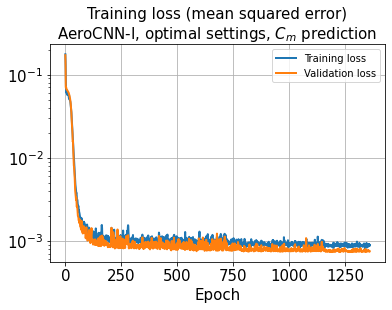

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

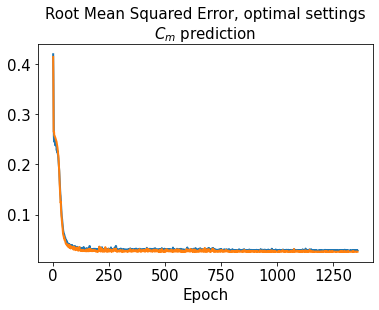

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

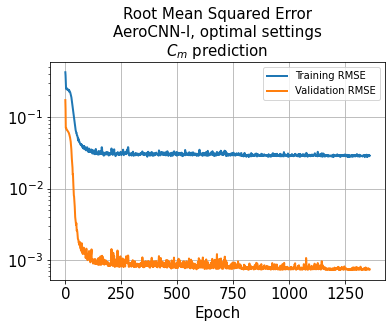

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 5ms/step - loss: 8.6570e-04 - rmse: 0.0283


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 6ms/step - loss: 7.3935e-04 - rmse: 0.0260


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 7ms/step - loss: 9.3372e-04 - rmse: 0.0295


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.06567456478835629
2.4804790338486815


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.05862683187138358
2.3090596097691796


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.06469053042220411
2.4495128265375827


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230103"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.001)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

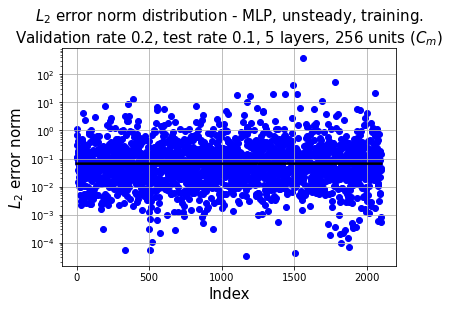

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

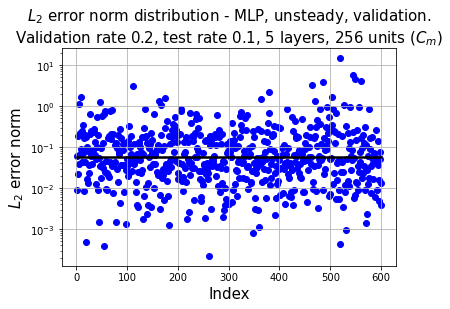

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

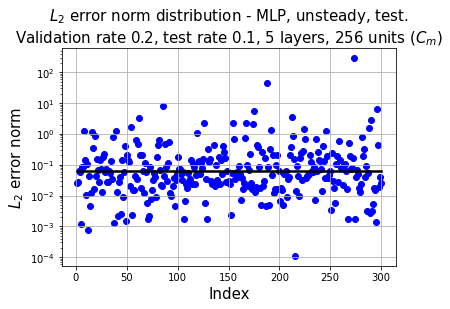

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 3ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9623447], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.06417285906336348


In [67]:
cm[2000]

array([0.00682824])

In [68]:
cm[1000]

array([0.0014248])

In [69]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [73]:
len(predicted[index_train])

2100

In [74]:
len(predicted[index_val])

601

In [75]:
len(predicted[index_test])

301

In [76]:
x_time += 10

L2 error of Cm: 0.0780


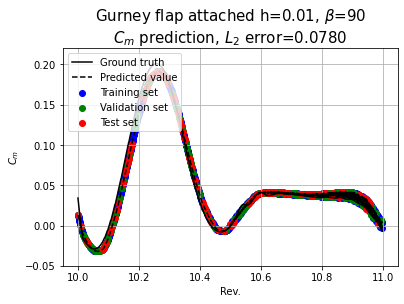

L2 error of Cm: 0.0135


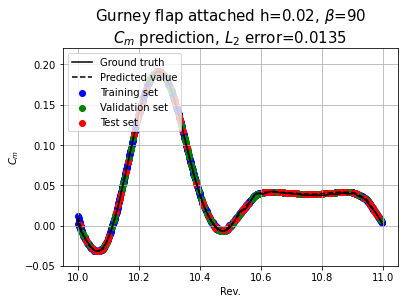

L2 error of Cm: 0.0779


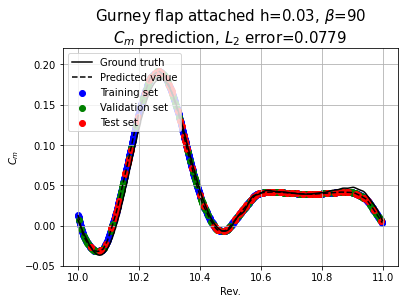

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [78]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0780


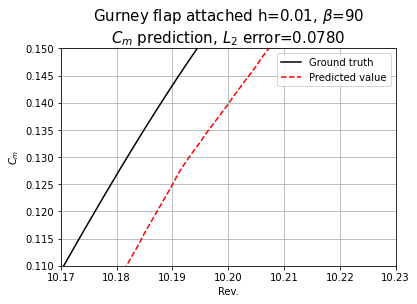

L2 error of Cm: 0.0135


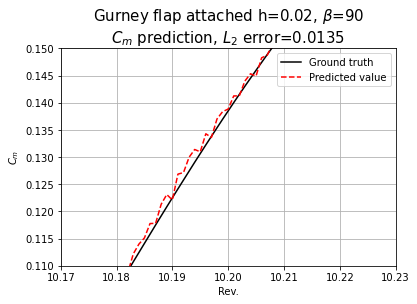

L2 error of Cm: 0.0779


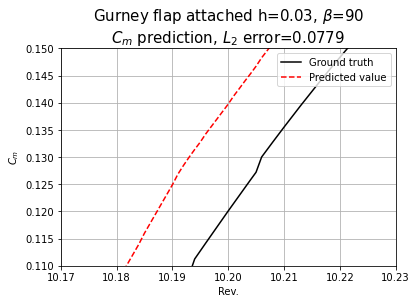

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0780


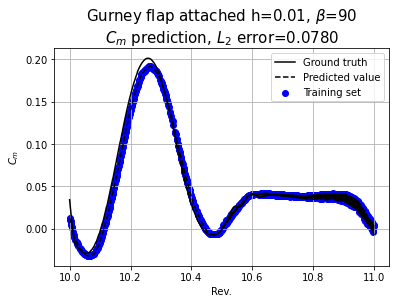

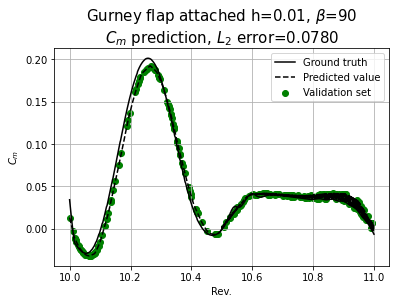

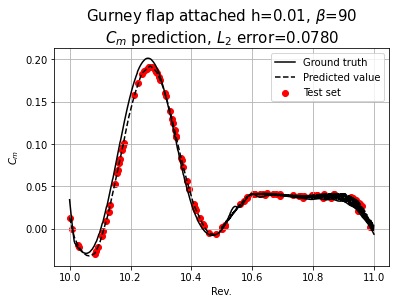

L2 error of Cm: 0.0135


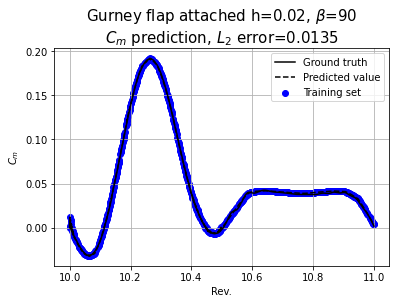

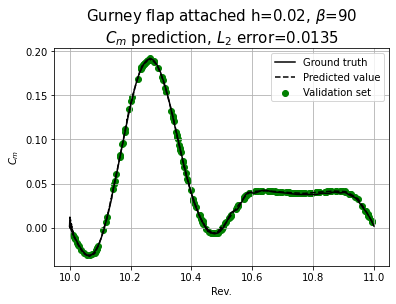

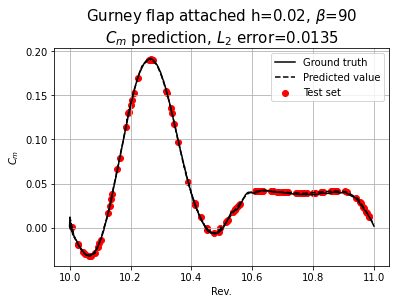

L2 error of Cm: 0.0779


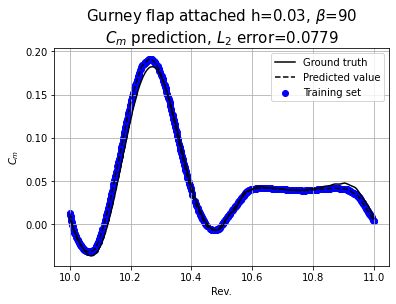

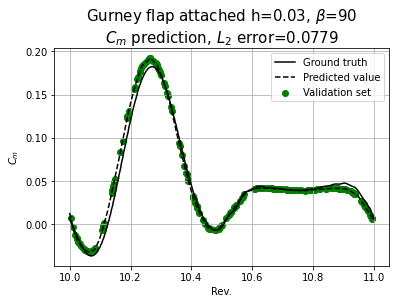

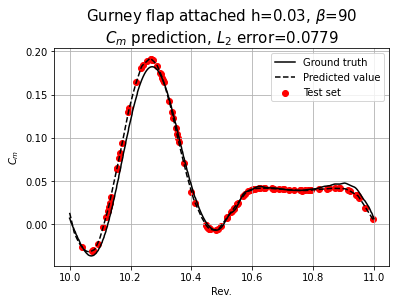

In [81]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()